# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pathlib, glob, math, random
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, mean_absolute_percentage_error

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasBayesianSearch
from hyperopt import hp, Trials

from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
data_dir = "PB/"
data_dir = pathlib.Path(data_dir)
folder = list(data_dir.glob('*'))
print('Folder Structure:')
for f in folder:
    print(f)

Folder Structure:
PB\Precio_Bolsa_Nacional_($kwh)_2018.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2019.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2020.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2021.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2022.xlsx


In [3]:
datosPB = pd.DataFrame()
for f in sorted(glob.glob(str(data_dir)+"/*.xlsx")):
  df = pd.read_excel(f, engine='openpyxl', header=2)
  datosPB = pd.concat([datosPB,df], axis=0, sort=False, ignore_index=True)
datosPB = datosPB.dropna(axis=1)
datosPB = datosPB.drop(labels=['Fecha'],axis=1)
datosPB = pd.DataFrame({"Electricity_Bid_Price":datosPB.stack().reset_index(drop=True)})
rng = pd.date_range(start = '2018-01-01 00:00', end ='2022-12-31 23:00', freq='h')
datosPB = datosPB.set_index(rng)
print(datosPB.shape)
datosPB.head(5)

(43824, 1)


,Electricity_Bid_Price
2018-01-01 00:00:00,123.167294
2018-01-01 01:00:00,123.167294
2018-01-01 02:00:00,123.167294
2018-01-01 03:00:00,123.167294
2018-01-01 04:00:00,123.167294


In [4]:
datosPB.describe()

,Electricity_Bid_Price
count,43824.000000
mean,192.334540
std,111.884471
min,61.458535
25%,102.739564
50%,159.170000
75%,253.030000
max,1035.130000


# Data Pre-processing

## Train-test Splitting

In [5]:
fin_train = '2021-12-31 23:00:00'
inicio_prueba = '2022-01-01 00:00:00'

datosPB_train = datosPB.loc[: fin_train, :]
datosPB_test = datosPB.loc[inicio_prueba:, :]

train_size = datosPB_train.shape[0]
test_size = datosPB_test.shape[0]

print(f"Fechas train      : {datosPB_train.index.min()} --- {datosPB_train.index.max()}")
print(f"Fechas test       : {datosPB_test.index.min()} --- {datosPB_test.index.max()}")

Fechas train      : 2018-01-01 00:00:00 --- 2021-12-31 23:00:00
Fechas test       : 2022-01-01 00:00:00 --- 2022-12-31 23:00:00


## Data Scaling

In [6]:
TRFscaler = StandardScaler()
TRFscaler = TRFscaler.fit(datosPB_train)
datosPB_train_TRF = TRFscaler.transform(datosPB_train)
datosPB_test_TRF = TRFscaler.transform(datosPB_test)

## Data Transformer Formatting

In [7]:
time_lags = 24
f_window = 8

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
   n_vars = 1 if type(data) is list else data.shape[1]
   df = pd.DataFrame(data)
   cols, names = list(), list()
   # input sequence (t-n, ... t-1)
   for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
   # forecast sequence (t, t+1, ... t+n)
   for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
   return agg

In [9]:
#data_train, data_test = series_to_supervised(datosPB_train, time_lags, f_window), series_to_supervised(datosPB_test, time_lags, f_window)
data_train, data_test = series_to_supervised(datosPB_train_TRF, time_lags, f_window), series_to_supervised(datosPB_test_TRF, time_lags, f_window)
data_train.shape, data_test.shape

((35033, 32), (8729, 32))

In [10]:
X_train_TRF, X_test_TRF = data_train.values[:, 0:time_lags], data_test.values[:, 0:time_lags]
y_train_TRF, y_test_TRF = data_train.values[:, time_lags:], data_test.values[:, time_lags:]
print(X_train_TRF.shape,  X_test_TRF.shape, y_train_TRF.shape, y_test_TRF.shape)
X_train_TRF, X_test_TRF= X_train_TRF.reshape(X_train_TRF.shape[0], X_train_TRF.shape[1], 1), X_test_TRF.reshape(X_test_TRF.shape[0], X_test_TRF.shape[1], 1)
print(X_train_TRF.shape,  X_test_TRF.shape, y_train_TRF.shape, y_test_TRF.shape)

(35033, 24) (8729, 24) (35033, 8) (8729, 8)
(35033, 24, 1) (8729, 24, 1) (35033, 8) (8729, 8)


# Model Building

In [17]:
def quantile_loss(tau, y_true, y_pred):
    err = (y_true - y_pred)
    return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)

### Transformers

In [11]:
class T2V(Layer):

  def __init__(self, output_dim=None, **kwargs):
    self.output_dim = output_dim
    super(T2V, self).__init__(**kwargs)

  def build(self, input_shape):
    self.W = self.add_weight(name='W',
                             shape=(input_shape[-1], self.output_dim),
                             initializer='uniform',
                             trainable=True)

    self.P = self.add_weight(name='P',
                             shape=(input_shape[1], self.output_dim),
                             initializer='uniform',
                             trainable=True)

    self.w = self.add_weight(name='w',
                             shape=(input_shape[1], 1),
                             initializer='uniform',
                             trainable=True)

    self.p = self.add_weight(name='p',
                             shape=(input_shape[1], 1),
                             initializer='uniform',
                             trainable=True)

    super(T2V, self).build(input_shape)

  def call(self, x):
    original = self.w * x + self.p
    sin_trans = K.sin(K.dot(x, self.W) + self.P)
    return K.concatenate([sin_trans, original], -1)

In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    res = x + inputs
    res = LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part
    x = Conv1D(ff_dim, activation="relu", kernel_size=1)(res)
    x = Dropout(dropout)(x)
    x = Conv1D(inputs.shape[-1], kernel_size=1)(x)
    out = x + res
    out = LayerNormalization(epsilon=1e-6)(out)

    return out

In [13]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def T2V_TRF_ENC(param, dimen):
    set_seed(33)
    inputs = Input(shape=(dimen,1))
    x = T2V(dimen)(inputs)
    #x = inputs
    x = Concatenate(axis=-1)([inputs, x])
    for _ in range(param['trf_block']):
        x = transformer_encoder(x, param['head_size'], param['n_heads'], param['ff_dim'], param['dropout'])
    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in [param['mlp_units']]:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(param['mlp_drop'])(x)
    outputs_min = Dense(f_window, name='outputs_min')(x)
    outputs_med = Dense(f_window, name='outputs_med')(x)
    outputs_max = Dense(f_window, name='outputs_max')(x)
    m = Model(inputs, outputs=[outputs_min, outputs_med, outputs_max])
    m.compile(loss={'outputs_min': lambda y_true, y_pred: quantile_loss(0.05, y_true, y_pred),
                    'outputs_med': lambda y_true, y_pred: quantile_loss(0.5, y_true, y_pred),
                    'outputs_max': lambda y_true, y_pred: quantile_loss(0.95, y_true, y_pred)},
              metrics=['mae', 'mape'], optimizer=Adam(learning_rate=1e-3))
    return m

In [14]:
param_grid = {
    'head_size': 128 + hp.randint('head_size', 128),
    'n_heads': 2 + hp.randint('n_heads', 6),
    'ff_dim': 2 + hp.randint('ff_dim', 2),
    'trf_block': 2 + hp.randint('trf_block', 6),
    'mlp_units': 64 + hp.randint('mlp_units', 128),
    'mlp_drop': 0.4,
    'dropout': 0.2,
    'lr': 1e-3,
    'epochs': 200,
    'batch_size': 128
}

In [18]:
callbacks = [EarlyStopping(patience=10, restore_best_weights=True),\
             ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose = 1, factor = 0.8, min_lr = 1e-5)]

hypermodel_TRF = lambda x: T2V_TRF_ENC(param=x, dimen=time_lags)

kgs_t2v_TRF = KerasBayesianSearch(hypermodel_TRF, param_grid, monitor='val_loss',
                                  greater_is_better=False, tuner_verbose=1,
                                  n_iter=16, sampling_seed=33)

kgs_t2v_TRF.search(X_train_TRF,[y_train_TRF, y_train_TRF, y_train_TRF], trials=Trials(),
                   validation_split=0.2,callbacks=[callbacks], shuffle=True)


16 trials detected for ('head_size', 'n_heads', 'ff_dim', 'trf_block', 'mlp_units', 'mlp_drop', 'dropout', 'lr', 'epochs', 'batch_size')

***** (1/16) *****
Search({'batch_size': 128, 'dropout': 0.2, 'epochs': 200, 'ff_dim': 2, 'head_size': 248, 'lr': 0.001, 'mlp_drop': 0.4, 'mlp_units': 122, 'n_heads': 4, 'trf_block': 4})

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 31: ReduceLROnPlateau reducing learning ra

In [19]:
kgs_t2v_TRF.best_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 24, 1)]      0           []                               
                                                                                                  
 t2v_11 (T2V)                   (None, 24, 25)       648         ['input_12[0][0]']               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 24, 26)       0           ['input_12[0][0]',               
                                                                  't2v_11[0][0]']                 
                                                                                                  
 multi_head_attention_44 (Multi  (None, 24, 26)      60695       ['concatenate_11[0][0]',  

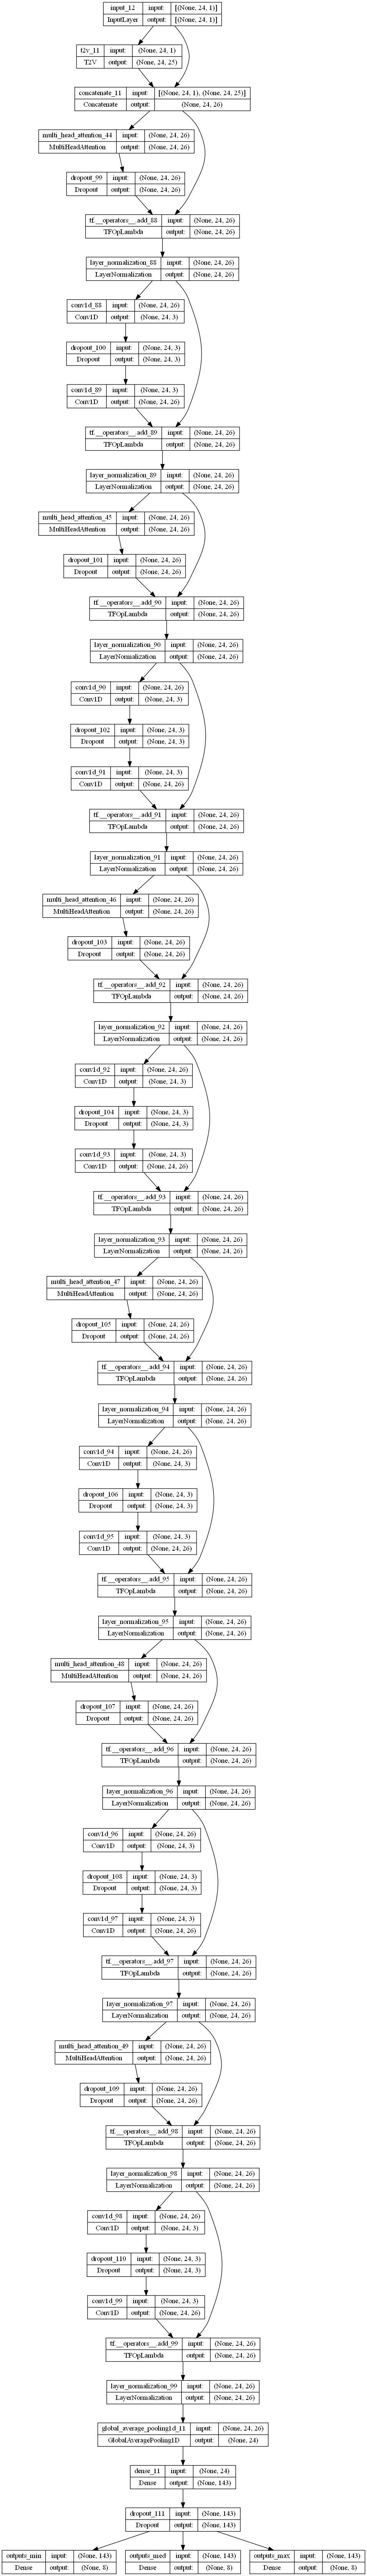

In [20]:
dot_img_file = 'model_T2V-TE.png'
tf.keras.utils.plot_model(kgs_t2v_TRF.best_model, to_file=dot_img_file, show_shapes=True)

# Forecasting

In [21]:
predictionsTRF = kgs_t2v_TRF.best_model.predict(X_test_TRF)

273/273 [==============================] - 3s 11ms/step


In [22]:
#lower, upper = predictionsTRF[0][:,0].reshape(-1,1) - 1, predictionsTRF[2][:,0].reshape(-1,1) - 1
#lower, upper = np.e**(TRFscaler.inverse_transform(predictionsTRF[0][:,0].reshape(-1,1)))-1, np.e**(TRFscaler.inverse_transform(predictionsTRF[2][:,0].reshape(-1,1)))-1
lower, upper = TRFscaler.inverse_transform(predictionsTRF[0][:,0].reshape(-1,1)), TRFscaler.inverse_transform(predictionsTRF[2][:,0].reshape(-1,1))
#pred_TRF = predictionsTRF[1][:,0].reshape(-1,1) - 1
#pred_TRF = np.e**(TRFscaler.inverse_transform(predictionsTRF[1][:,0].reshape(-1,1)))-1
pred_TRF = TRFscaler.inverse_transform(predictionsTRF[1][:,0].reshape(-1,1))
#real_data = y_test_TRF - 1
#real_data = np.e**(TRFscaler.inverse_transform(y_test_TRF)) - 1
real_data = TRFscaler.inverse_transform(y_test_TRF)

In [23]:
print("MSE:", mean_squared_error(real_data[:,0], pred_TRF))
print("RMSE:", math.sqrt(mean_squared_error(real_data[:,0], pred_TRF)))
print("MAE:", mean_absolute_error(real_data[:,0], pred_TRF))
print("R2:", r2_score(real_data[:,0], pred_TRF))
print("MAPE:", mean_absolute_percentage_error(real_data[:,0], pred_TRF)*100)

MSE: 1123.2554429803777
RMSE: 33.5150032519822
MAE: 13.197186775954814
R2: 0.9300461119412311
MAPE: 5.431785838552024


## Prediccion unica Quarters

In [24]:
pred_TRF_Q1 = pred_TRF[:2112]
real_data_Q1 = real_data[:,0][:2112]

print("RMSE TRF:", math.sqrt(mean_squared_error(real_data_Q1, pred_TRF_Q1)))
print("MAE TRF:", mean_absolute_error(real_data_Q1, pred_TRF_Q1))
print("MAPE TRF:", mean_absolute_percentage_error(real_data_Q1, pred_TRF_Q1)*100)
print("R2:", r2_score(real_data_Q1, pred_TRF_Q1))

RMSE TRF: 29.442155199162688
MAE TRF: 15.695111916281958
MAPE TRF: 4.980939157619113
R2: 0.9526955272766429


In [25]:
pred_TRF_Q2 = pred_TRF[2112:4296]
real_data_Q2 = real_data[:,0][2112:4296]

print("RMSE TRF:", math.sqrt(mean_squared_error(real_data_Q2, pred_TRF_Q2)))
print("MAE TRF:", mean_absolute_error(real_data_Q2, pred_TRF_Q2))
print("MAPE TRF:", mean_absolute_percentage_error(real_data_Q2, pred_TRF_Q2)*100)
print("R2:", r2_score(real_data_Q2, pred_TRF_Q2))

RMSE TRF: 28.61092568206105
MAE TRF: 6.547116029760342
MAPE TRF: 4.126578243713756
R2: 0.6705408329882885


In [26]:
pred_TRF_Q3 = pred_TRF[4296:6503]
real_data_Q3 = real_data[:,0][4296:6503]

print("RMSE TRF:", math.sqrt(mean_squared_error(real_data_Q3, pred_TRF_Q3)))
print("MAE TRF:", mean_absolute_error(real_data_Q3, pred_TRF_Q3))
print("MAPE TRF:", mean_absolute_percentage_error(real_data_Q3, pred_TRF_Q3)*100)
print("R2:", r2_score(real_data_Q3, pred_TRF_Q3))

RMSE TRF: 29.4001028630934
MAE TRF: 11.077048351182407
MAPE TRF: 5.192376274682008
R2: 0.8950215078755017


In [27]:
pred_TRF_Q4 = pred_TRF[6503:8706]
real_data_Q4 = real_data[:,0][6503:8706]

print("RMSE TRF:", math.sqrt(mean_squared_error(real_data_Q4, pred_TRF_Q4)))
print("MAE TRF:", mean_absolute_error(real_data_Q4, pred_TRF_Q4))
print("MAPE TRF:", mean_absolute_percentage_error(real_data_Q4, pred_TRF_Q4)*100)
print("R2:", r2_score(real_data_Q4, pred_TRF_Q4))

RMSE TRF: 43.813416110330856
MAE TRF: 19.31294953722441
MAPE TRF: 7.387978525534387
R2: 0.8479162621064368


## Predicción Probabilistica

In [28]:
errors_TRF = real_data - pred_TRF

In [29]:
mpiw = np.mean(upper - lower)
inside_bounds = np.logical_and(real_data[:,0] > lower[:,0], real_data[:,0] < upper[:,0])  # Encontrar predicciones que caen dentro del intervalo de predicción
picp = np.mean(inside_bounds)
pinaw = (mpiw/(datosPB.Electricity_Bid_Price.max() - datosPB.Electricity_Bid_Price.min()))*100
print("MPIW:",mpiw)
print("PICP:",picp)
print("PINAW:",pinaw)

MPIW: 71.38247
PICP: 0.9503952342765495
PINAW: 7.331268476399899


# Plots

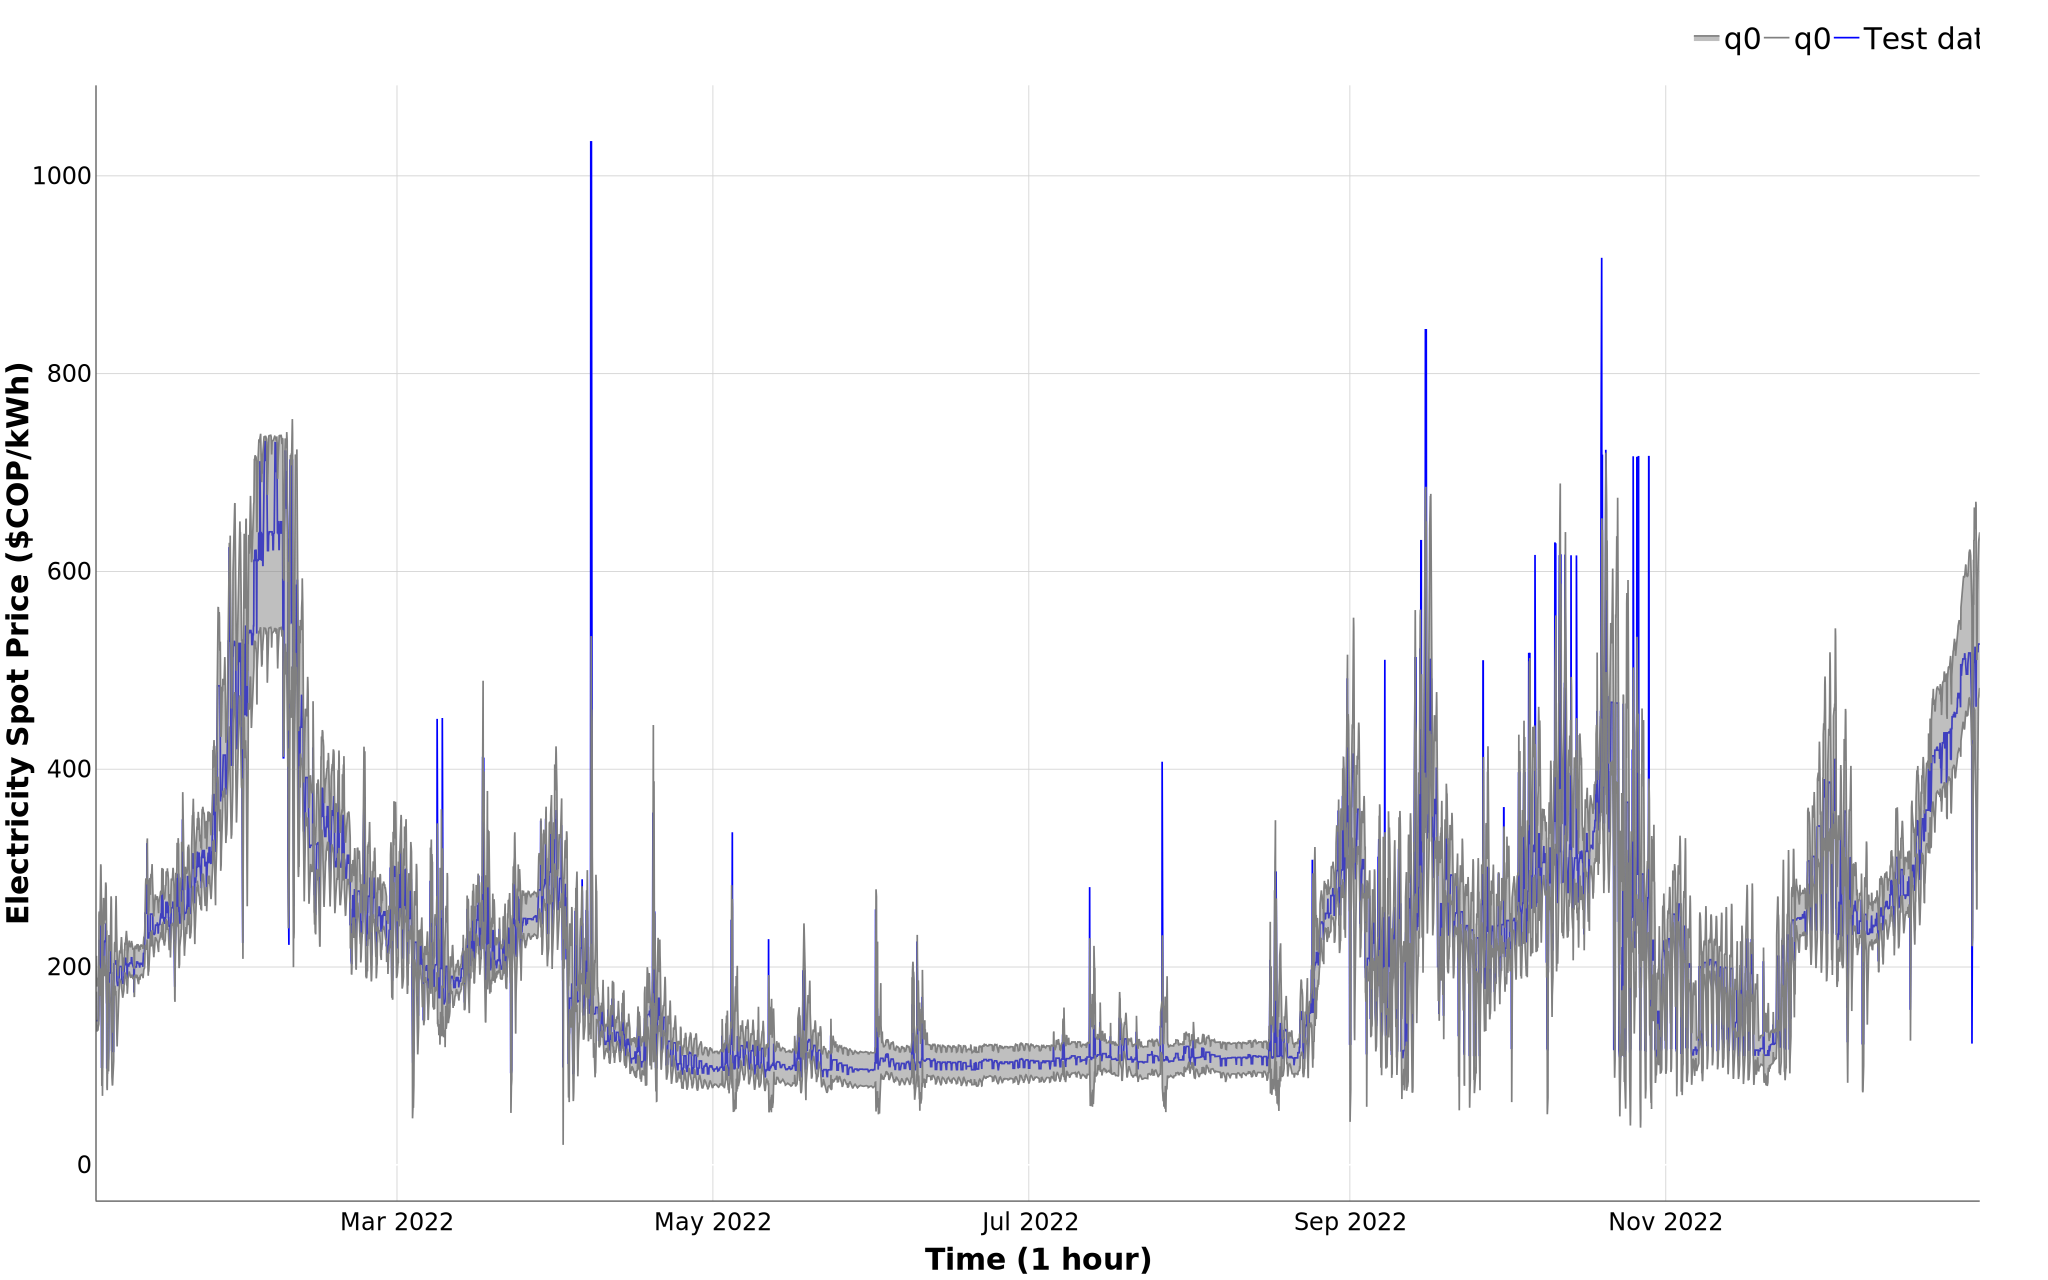

In [30]:
figPBCom = make_subplots(rows=1, cols=1)


figPBCom.append_trace(go.Scatter(y=real_data[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", stackgaps='infer zero'), row=1, col=1)
#figPBCom.append_trace(go.Scatter(y=predictionsTRF[:,0], x=datosPB_test.index[time_lags-1:],
#                                 mode='lines', line=dict(width=2, color="gold"),
#                                 name="Transformer", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=upper[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="q0", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=lower[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="q0", stackgaps='infer zero', fill='tonexty'), row=1, col=1)


figPBCom.update_layout(title='',
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=2400,height=1500,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black"),
                      font=dict(family="Fira Sans, Condensed", color='black'),
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=35, font_color='black'),
                      showlegend=True)
#figPBCom.update_xaxes(range=['2022-01-01 00:00:00','2022-01-10 00:00:00'])
figPBCom.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Time (1 hour)</b>', titlefont_size=35, tickfont_size=28)
figPBCom.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>Electricity Spot Price ($COP/kWh)</b>', titlefont_size=35, tickfont_size=28)
figPBCom.update_traces(connectgaps=False)
figPBCom.update_annotations(font=dict(size=35))
figPBCom.show("svg")

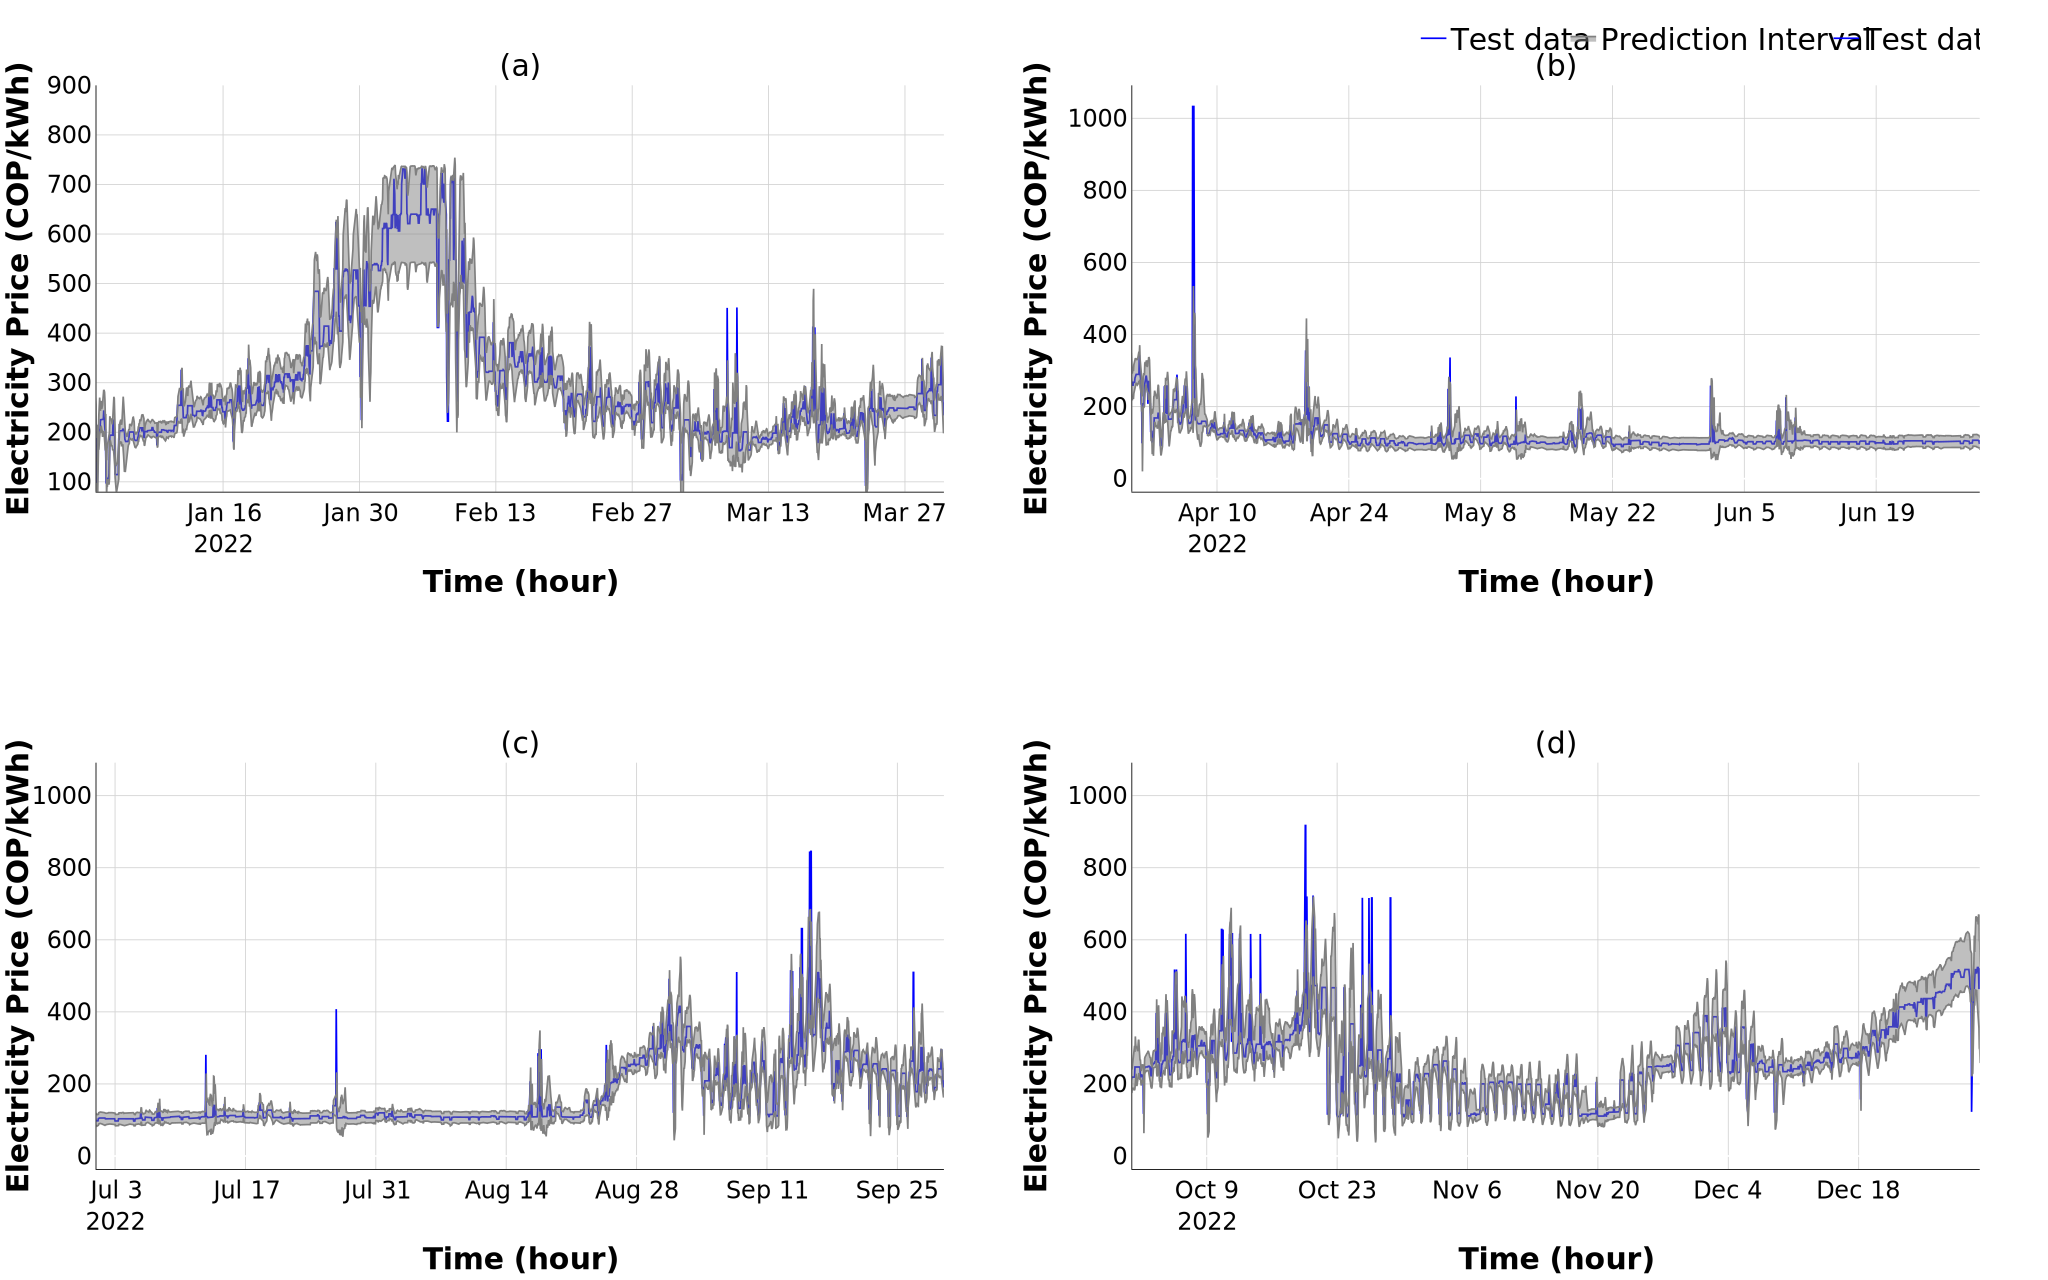

In [31]:
figPBCom2 = make_subplots(rows=2, cols=2, subplot_titles = ['(a)','(b)','(c)','(d)'])


figPBCom2.append_trace(go.Scatter(y=real_data[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", stackgaps='infer zero'), row=1, col=1)
#figPBCom2.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
#                                 mode='lines', line=dict(width=2, color="gold"),
#                                 name="Stacked-LSTM", stackgaps='infer zero'), row=1, col=1)
figPBCom2.append_trace(go.Scatter(y=upper[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero'), row=1, col=1)
figPBCom2.append_trace(go.Scatter(y=lower[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", stackgaps='infer zero', fill='tonexty'), row=1, col=1)


figPBCom2.append_trace(go.Scatter(y=real_data[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False, stackgaps='infer zero'), row=2, col=1)
#figPBCom2.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
#                                 mode='lines', line=dict(width=2, color="gold"),
#                                 name="Stacked-LSTM", stackgaps='infer zero'), row=2, col=1)
figPBCom2.append_trace(go.Scatter(y=upper[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero'), row=2, col=1)
figPBCom2.append_trace(go.Scatter(y=lower[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero', fill='tonexty'), row=2, col=1)


figPBCom2.append_trace(go.Scatter(y=real_data[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", stackgaps='infer zero'), row=1, col=2)
#figPBCom2.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
#                                 mode='lines', line=dict(width=2, color="gold"),
#                                 name="Stacked-LSTM", stackgaps='infer zero'), row=1, col=1)
figPBCom2.append_trace(go.Scatter(y=upper[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero'), row=1, col=2)
figPBCom2.append_trace(go.Scatter(y=lower[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero', fill='tonexty'), row=1, col=2)


figPBCom2.append_trace(go.Scatter(y=real_data[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False, stackgaps='infer zero'), row=2, col=2)
#figPBCom2.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
#                                 mode='lines', line=dict(width=2, color="gold"),
#                                 name="Stacked-LSTM", stackgaps='infer zero'), row=1, col=1)
figPBCom2.append_trace(go.Scatter(y=upper[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero'), row=2, col=2)
figPBCom2.append_trace(go.Scatter(y=lower[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="Prediction Interval", showlegend=False, stackgaps='infer zero', fill='tonexty'), row=2, col=2)


figPBCom2.update_layout(title='',
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=2400,height=1500,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black"),
                      font=dict(family="Fira Sans Condensed", color='black'),
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=35, font_color='black'),
                      showlegend=True)

figPBCom2.update_xaxes(range=['2022-01-03 00:00:00','2022-03-31 00:00:00'], row=1,col=1)
figPBCom2.update_xaxes(range=['2022-04-01 00:00:00','2022-06-30 00:00:00'], row=1,col=2)
figPBCom2.update_xaxes(range=['2022-07-01 00:00:00','2022-09-30 00:00:00'], row=2,col=1)
figPBCom2.update_xaxes(range=['2022-10-01 00:00:00','2022-12-31 00:00:00'], row=2,col=2)


figPBCom2.update_yaxes(range=[80,900], row=1,col=1)

figPBCom2.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Time (hour)</b>', titlefont_size=35, tickfont_size=28)
figPBCom2.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>Electricity Price (COP/kWh)</b>', titlefont_size=35, tickfont_size=28)
figPBCom2.update_traces(connectgaps=False)
figPBCom2.update_annotations(font=dict(size=35))
figPBCom2.show("svg")

In [32]:
np.savetxt("Forecasting_Results/Results_TRF.csv", np.column_stack((lower,pred_TRF,upper,errors_TRF)), delimiter=",")